In [50]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
def read_file(f):
    '''convert a csv file to a pd DataFrame. Also parse the filename into vole1/vole2/day/experiment
    and return as a dict.'''
    
    with open(f) as fi:
        dat = [line for line in fi]
    header = 0
    for line in dat:
        if not 'event' in line:
            header+=1
        else:
            break

    df = pd.read_csv(f, skiprows=header)
    _, fname = os.path.split(f)
    #vvvvv this should get replaced with a header in each filef
    vole1 = fname.split('_')[0]
    vole2 = fname.split('_')[1]
    day = fname.split('_')[-1].split('.')[0]
    experiment = fname.split('__')[-1].split('_day')[0]
    return df, {'vole1':vole1, 'vole2':vole2,'day': day, 'experiment':experiment,}

def analyze_file(f):
    df, info_dict = read_file(f)
    return analyze_df(df), info_dict
    
    
def analyze_df(df):
    counts = get_event_counts(df)
    latencies = get_event_latencies(df)
    
    return [counts, latencies]

def get_event_counts(df):
    '''read a DataFrame and count the occurences of every unique event within the "event" column'''
    counts = {}
    for e in df.event.unique():
        counts[f'{e}_count'] = len(df.loc[df.event == e])
    return counts

def get_event_latencies(df):
    '''read a DataFrame, and get mean and median latencies for any events with associated latencies. Will not count
    events that have no associated latencies, even if they exist for other animals. (should fix this)'''
    e_list = df.loc[pd.notna(df.latency), 'event'].unique()
    latencies = {}
    for e in e_list:
        latencies[f'{e}_latency_mean'] = round(df.loc[df.event == e, 'latency'].mean(), 5)
        latencies[f'{e}_latency_median'] = round(df.loc[df.event == e, 'latency'].median(),5)
        
    return latencies

def parse_file(file):
    '''read a file, and convert it to a summary of counts, median latencies, and mean latencies.'''
    _, fname = os.path.split(file)
    dicts, info = analyze_file(file)
    out = []
    
    
    
    cols = [col for col in info.keys()]
    vals = [info[key] for key in cols]
    cols+=['metric', 'value','file']
    
    for dict in dicts:
        for key, value in dict.items():
            tmp = []
            tmp+=vals
            tmp+=[key,value, fname]
            out+=[tmp]
    
    return pd.DataFrame(data = np.asarray(out), columns = cols)
    
def assemble_files(directory):
    '''return a list of paths to files to parse'''
    os.chdir(directory)

    #create an empty 2d list
    out_names = []

    #this will assemble a list of ALL filenames for images, sorted by timestamp of acquisition


    for root, dirs, files in os.walk(directory):
        out = [os.path.join(root, f) for f in sorted(files) if
            f.endswith('.csv') if not 'summary' in f if not 'error' in f]
        out_names += out
    return out_names

def parse_directory(dir):
    '''read all files in a dir, and add to a large output dataframe'''
    files = assemble_files(dir)
    out_df = parse_file(files[0])
    for file in files[1:]:
        out_df = out_df.append(parse_file(file))
    return out_df

def summarize_directory(dir, output_file_name = None, output_file_dir = None):
    '''use this to parse a directory and save it to a csv file. Will search deeply within a directory (IE a 
    directory of directories.)
    dir              --> input directory (path)
    output_file_name --> name for the summary file. default "summary.csv" (string)
    output_file_dir  --> where to save the summary. Default is same dir as input (path)'''
    
    if output_file_dir == None:
        output_file_dir = dir
    if not output_file_name:
        output_file_name = 'summary.csv'
    output_file_path = os.path.join(output_file_dir, output_file_name)
    
    out_df = parse_directory(dir)
    out_df.to_csv(output_file_path)
    

In [4]:
cwd = os.getcwd()

In [75]:


summarize_directory(os.path.join(cwd,'cohort_2'))

In [6]:
df = pd.read_csv(os.path.join(cwd,'output', 'summary.csv'))

In [76]:
df2 = pd.read_csv(os.path.join(cwd,'cohort_2', 'summary.csv'))

In [7]:
df.head()

,Unnamed: 0,vole1,vole2,day,experiment,metric,value,file
0,0,5119,0,1,magazine,trigger_count,1.0,5119_0_10_17_2022___16_50__magazine_day_1.csv
1,1,5119,0,1,magazine,new_round_count,1.0,5119_0_10_17_2022___16_50__magazine_day_1.csv
2,2,5119,0,1,magazine,output_activated_count,2.0,5119_0_10_17_2022___16_50__magazine_day_1.csv
3,3,5119,0,1,magazine,tone_start_round_start_count,1.0,5119_0_10_17_2022___16_50__magazine_day_1.csv
4,4,5119,0,1,magazine,lever_extended_food_count,1.0,5119_0_10_17_2022___16_50__magazine_day_1.csv


In [32]:
def check_search_type(df, col, values):
    if values[0] == str:
        if not df[col].dtype == 'object':
            raise TypeError(f'Wrong Type when searching dataframe. df["{col}"] type is {df[col].dtype}, but str was provided')
        if not all([type(v) == str for v in values]):
            return [str(v) for v in values]
        
    elif not all([type(v) == df[col].dtype] for v in values):
        for v in values:
            if not type(v) == df[col].dtype:
                raise TypeError(f'Wrong Type when searching dataframe. df["{col}"] type is {df[col].dtype}, but {type(v)} was provided')
    return values
            
def get_data(df, **kwargs):
    sli = df.copy()
    for arg, val, in kwargs.items():
        if not arg in df.columns:
            raise NameError(f'argument "{arg}" not found in dataframe columns')
        else:
            if not isinstance(val, list):
                val =[val]
                val = check_search_type(df, arg, val)
            sli = sli.loc[sli[arg].isin(val)]
            
    return sli

In [44]:
get_data(df, vole1='5119', experiment =['autotrain','autotrain_contingent'],  metric ='pellet_retrieved_count')

,Unnamed: 0,vole1,vole2,day,experiment,metric,value,file
129,13,5119,0,1,autotrain,pellet_retrieved_count,28.0,5119_0_10_24_2022___16_58__autotrain_day_1.csv
144,8,5119,0,2,autotrain,pellet_retrieved_count,26.0,5119_0_10_25_2022___13_3__autotrain_day_2.csv
182,14,5119,0,3,autotrain,pellet_retrieved_count,30.0,5119_0_10_26_2022___15_40__autotrain_day_3.csv
200,11,5119,0,4,autotrain,pellet_retrieved_count,30.0,5119_0_10_27_2022___13_26__autotrain_day_4.csv
224,14,5119,0,5,autotrain_contingent,pellet_retrieved_count,32.0,5119_0_10_28_2022___11_55__autotrain_contingen...


In [86]:
get_data(df, vole1='5119', experiment =['autotrain','autotrain_contingent'],  metric ='new_round_count')

,Unnamed: 0,vole1,vole2,day,experiment,metric,value,file
159,1,5119,0,3,autotrain,new_round_count,1.0,5119_0_10_26_2022___15_36__autotrain_day_3.csv
163,1,5119,0,3,autotrain,new_round_count,1.0,5119_0_10_26_2022___15_39__autotrain_day_3.csv
169,1,5119,0,3,autotrain,new_round_count,15.0,5119_0_10_26_2022___15_40__autotrain_day_3.csv
190,1,5119,0,4,autotrain,new_round_count,15.0,5119_0_10_27_2022___13_26__autotrain_day_4.csv
211,1,5119,0,5,autotrain_contingent,new_round_count,20.0,5119_0_10_28_2022___11_55__autotrain_contingen...
233,1,5119,0,5,autotrain,new_round_count,3.0,5119_0_10_28_2022___9_43__autotrain_day_5.csv
252,1,5119,0,5,autotrain_contingent,new_round_count,3.0,5119_0_10_28_2022___9_46__autotrain_contingent...
271,1,5119,0,5,autotrain_contingent,new_round_count,2.0,5119_0_10_28_2022___9_50__autotrain_contingent...


Text(0, 0.5, 'pct presses\n(presses/opportunities)')

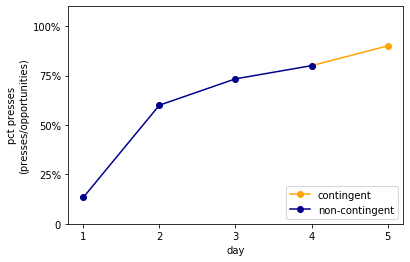

In [89]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
ax.plot([4,5], [12/15,18/20], '-o', color = 'orange', label = 'contingent')
ax.plot([1,2,3,4], [2/15,9/15,11/15,12/15], '-o', color ='darkblue', label = 'non-contingent'),
ax.set_ylim(0,1.1)
ax.set_xticks([1,2,3,4,5])
ax.set_yticks([0,0.25,0.50,0.75,1])
ax.set_yticklabels(('0','25%','50%','75%','100%'))
ax.legend(loc = 4)
ax.set_xlabel('day')
ax.set_ylabel('pct presses\n(presses/opportunities)')


In [98]:
get_data(df2, vole1 = '4678'
         ,experiment =['autotrain','autotrain_contingent'],  metric ='lever_press_food_count')

,Unnamed: 0,vole1,vole2,day,experiment,metric,value,file
65,15,4678,0,1,autotrain,lever_press_food_count,2.0,4678_0_12_1_2022___12_49__autotrain_day_1.csv
105,15,4678,0,3,autotrain,lever_press_food_count,1.0,4678_0_12_5_2022___11_44__autotrain_day_3.csv
119,7,4678,0,1,autotrain_contingent,lever_press_food_count,5.0,4678_0_12_6_2022___11_30__autotrain_contingent...
141,7,4678,0,1,autotrain_contingent,lever_press_food_count,8.0,4678_0_12_6_2022___11_36__autotrain_contingent...
167,11,4678,0,2,autotrain_contingent,lever_press_food_count,4.0,4678_0_12_7_2022___13_5__autotrain_contingent_...


In [99]:
autotrain = {
             '4678':[2,0,1,13,4],
             '5120':[0,1,0,1,1],
             '5113':[13,15,15,15,14],
             '5116':[0,2,7,5,10]}

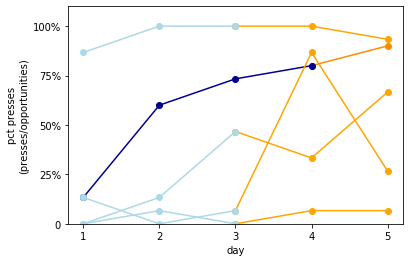

In [107]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
ax.plot([4,5], [12/15,18/20], '-o', color = 'darkorange', label = 'contingent')
ax.plot([1,2,3,4], [2/15,9/15,11/15,12/15], '-o', color ='darkblue', label = 'non-contingent'),
ax.set_ylim(0,1.1)
ax.set_xticks([1,2,3,4,5])
ax.set_yticks([0,0.25,0.50,0.75,1])
ax.set_yticklabels(('0','25%','50%','75%','100%'))
#ax.legend(loc = 0)
ax.set_xlabel('day')
ax.set_ylabel('pct presses\n(presses/opportunities)')

for ani, vals in autotrain.items():
    vals = [v/15 for v in vals]
    ax.plot([3,4,5], vals[-3:], '-o', color = 'orange', label = 'contingent')
    ax.plot([1,2,3,], vals[:-2], '-o', color ='lightblue', label = 'non-contingent'),
    

['lever_retracted_lever_1_count',
 'lever_extended_lever_1_count',
 'presses_reached_lever_1_count',
 'presses_reached_lever_1_latency_mean',
 'presses_reached_lever_1_latency_median',
 'lever_pressed_lever_1_count',
 'lever_extended_lever_1_|_lever_pressed_lever_1_count',
 'lever_extended_lever_1_|_lever_pressed_lever_1_latency_mean',
 'lever_extended_lever_1_|_lever_pressed_lever_1_latency_median']

In [138]:
out = get_data(df, vole1='5119'
         ,experiment =['door_train','door_train_contingent'],  metric ='presses_reached_lever_1_count')
out.sort_values('day')

,Unnamed: 0,vole1,vole2,day,experiment,metric,value,file
916,26,5119,5050,5,door_train,presses_reached_lever_1_count,4.0,5119_5050_10_31_2022___11_13__door_train_day_5...
959,25,5119,5050,5,door_train,presses_reached_lever_1_count,4.0,5119_5050_10_31_2022___11_35__door_train_day_5...
1510,25,5119,5056,6,door_train,presses_reached_lever_1_count,8.0,5119_5056_11_1_2022___12_47__door_train_day_6.csv
561,26,5119,5048,7,door_train,presses_reached_lever_1_count,8.0,5119_5048_11_2_2022___14_0__door_train_day_7.csv
382,25,5119,5047,8,door_train,presses_reached_lever_1_count,4.0,5119_5047_11_3_2022___15_28__door_train_day_8.csv
604,25,5119,5048,8,door_train,presses_reached_lever_1_count,4.0,5119_5048_11_3_2022___15_28__door_train_day_8.csv


Text(0.5, 1.0, 'novel')

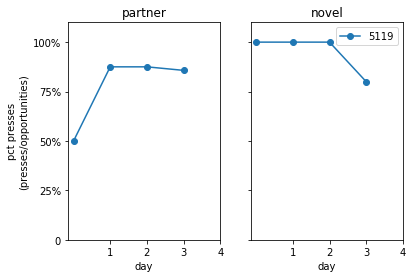

In [150]:
door_train={'5119':{'partner':[4/8,7/8,7/8,6/7], 'novel':[8/8, 8/8, 8/8, 4/5]},
            '4678':{'partner':[6/8,7/8,6/8], 'novel':[8/8,8/8, 7/8]},
            '5120':{'partner':[2/8,1/8,2/8], 'novel':[1/8,2/8, 1/8]},
            '5113':{'partner':[4/8,8/8,8/8], 'novel':[7/8,8/8,8/8]},
            '5116':{'partner':[3/8,3/8,6/8], 'novel':[2/8,6/8,5/8]}
            }


fig, axs = plt.subplots(ncols = 2)
fig.patch.set_facecolor('white')
for ani, vals in door_train.items():
    if ani == '5119':
        p = vals['partner']
        n = vals['novel']
        axs[0].plot([i for i in range(len(p))], p, '-o', label = ani)
        axs[1].plot([i for i in range(len(n))], n, '-o', label = ani)
        

for ax in axs:
    ax.set_ylim(0,1.1)
    ax.set_xticks([1,2,3,4])
    ax.set_yticks([0,0.25,0.50,0.75,1])

    #ax.legend(loc = 0)
    ax.set_xlabel('day')
axs[0].set_ylabel('pct presses\n(presses/opportunities)')
axs[0].set_yticklabels(('0','25%','50%','75%','100%'))
axs[1].set_yticklabels(())
axs[1].legend()
axs[0].set_title('partner')
axs[1].set_title('novel')



In [152]:
out = get_data(df, vole1='5119'
         ,experiment =['door_choice'],  metric ='presses_reached_lever_2_count')
out.sort_values('day')

,Unnamed: 0,vole1,vole2,day,experiment,metric,value,file
1291,14,5119,5050,1,door_choice,presses_reached_lever_2_count,1.0,5119_5050_11_4_2022___17_58__door_choice_day_1...
1226,16,5119,5050,1,door_choice,presses_reached_lever_2_count,1.0,5119_5050_11_4_2022___16_59__door_choice_day_1...
1199,22,5119,5050,1,door_choice,presses_reached_lever_2_count,1.0,5119_5050_11_4_2022___16_53__door_choice_day_1...
1166,22,5119,5050,1,door_choice,presses_reached_lever_2_count,1.0,5119_5050_11_4_2022___16_46__door_choice_day_1...
1133,22,5119,5050,1,door_choice,presses_reached_lever_2_count,1.0,5119_5050_11_4_2022___16_43__door_choice_day_1...
1354,25,5119,5050,1,door_choice,presses_reached_lever_2_count,3.0,5119_5050_11_4_2022___18_2__door_choice_day_1.csv
1627,25,5119,5056,2,door_choice,presses_reached_lever_2_count,5.0,5119_5056_11_7_2022___15_45__door_choice_day_2...
1550,22,5119,5056,2,door_choice,presses_reached_lever_2_count,1.0,5119_5056_11_7_2022___13_47__door_choice_day_2...
1577,16,5119,5056,2,door_choice,presses_reached_lever_2_count,1.0,5119_5056_11_7_2022___13_53__door_choice_day_2...
801,16,5119,5048,3,door_choice,presses_reached_lever_2_count,1.0,5119_5048_11_8_2022___14_2__door_choice_day_3.csv


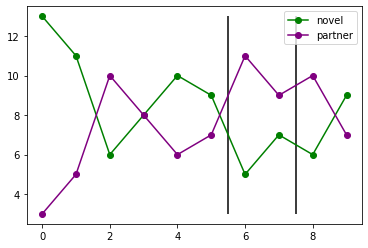

In [166]:
l1 = [13,11,6,8,10,9,5,7,6,9]
l2 = [3,5,10,8,6,7,11,9,10,7]

fig, ax = plt.subplots()
ax.plot(l1, '-o',color = 'green', label = 'novel')
ax.plot(l2, '-o',color = 'purple', label = 'partner')
ax.vlines(x = [5.5,7.5], ymin = 3, ymax = 13)
ax.legend()

Text(0.5, 1.0, 'novel')

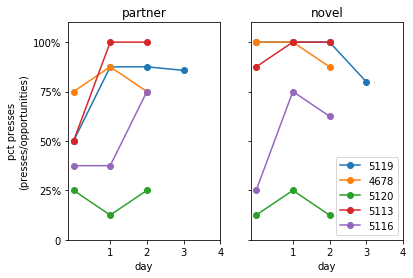

In [167]:
door_train={'5119':{'partner':[4/8,7/8,7/8,6/7], 'novel':[8/8, 8/8, 8/8, 4/5]},
            '4678':{'partner':[6/8,7/8,6/8], 'novel':[8/8,8/8, 7/8]},
            '5120':{'partner':[2/8,1/8,2/8], 'novel':[1/8,2/8, 1/8]},
            '5113':{'partner':[4/8,8/8,8/8], 'novel':[7/8,8/8,8/8]},
            '5116':{'partner':[3/8,3/8,6/8], 'novel':[2/8,6/8,5/8]}
            }


fig, axs = plt.subplots(ncols = 2)
fig.patch.set_facecolor('white')
for ani, vals in door_train.items():
    
    p = vals['partner']
    n = vals['novel']
    axs[0].plot([i for i in range(len(p))], p, '-o', label = ani)
    axs[1].plot([i for i in range(len(n))], n, '-o', label = ani)
        

for ax in axs:
    ax.set_ylim(0,1.1)
    ax.set_xticks([1,2,3,4])
    ax.set_yticks([0,0.25,0.50,0.75,1])

    #ax.legend(loc = 0)
    ax.set_xlabel('day')
axs[0].set_ylabel('pct presses\n(presses/opportunities)')
axs[0].set_yticklabels(('0','25%','50%','75%','100%'))
axs[1].set_yticklabels(())
axs[1].legend()
axs[0].set_title('partner')
axs[1].set_title('novel')